In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import units as u
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
import cmasher 
import glob as glob

label_file='10percent/10percent_labels.txt'
pyssed_files_glob='10percent/10percent_part*.dat'
pyssed_file='10percent/10percent_full.dat'

In [2]:
def param_update():

    plt.rcParams.update({'font.size': 10})
    plt.rcParams.update({'font.family': 'STIXGeneral'})
    plt.rcParams.update({'mathtext.fontset': 'stix'})
    pd.set_option("display.max_rows",5)
    pd.set_option("display.max_columns",None)

def glob_files(globstr):
    #write something which globbs the relevent files
    filelist=glob.glob(globstr)
    print("Files found via glob:")
    print(filelist)
    df_list=[]
    for file in filelist:
        sub_df = pd.read_table(file,skiprows=1,header=[1,2,3,4,5,6,7],low_memory=False)
        df_list.append(sub_df)
        if len(sub_df.index)<9010:
            print("Fewer than expected entries for {}: {}".format(file,len(sub_df.index) ))
    df=pd.concat(df_list)

    print("Processing data")
    # Extract text features
    cats = df.select_dtypes(exclude=np.number).columns.tolist()
    # Convert to Pandas category
    for col in cats:
       df[col] = df[col].astype('category')
    #force numeric columns where needed
    #can probably change this to select based on column name...
    for col in  df.columns[21:222]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    #check the above worked if needed
    #for i in range(0,239):
    #    print(i,output_df.dtypes[i])
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    features=df.replace('[]', np.nan).replace('--', np.nan)#.select_dtypes(include=numerics)
    features.to_csv('10percent/10percent_full.dat',sep='\t', index=False, quoting=3,escapechar="\t",na_rep='[]',header=True)

    return features

In [11]:
param_update()

labels=pd.read_table(label_file)
features_all = pd.read_table(pyssed_file,skiprows=1,header=[0,1,2,3,4,5],low_memory=False)
print(len(features.index),len(labels.index))

print(features.shape)

117128 117129
(117128, 442)


In [31]:
names=features.iloc[:,0]
features=features_all.iloc[:,1:].replace('[]', np.nan).replace('--', np.nan)


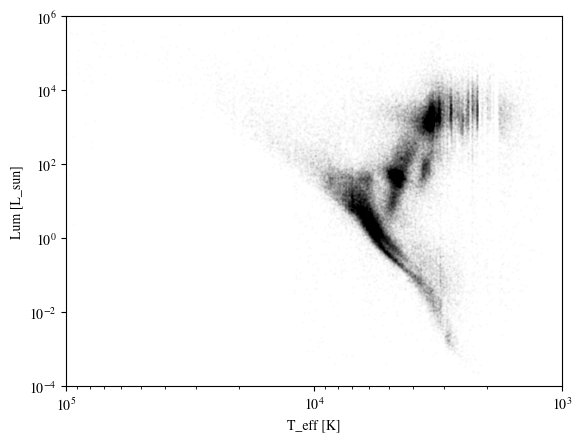

In [22]:
#s=5*(np.log10(np.asarray(output_df.iloc[:,10]))+4)
ax=features.plot.scatter(x='Teff', y='Lum',loglog=True,s=1,color='k',alpha=0.01)#,c=np.log(np.asarray(features.iloc[:,9])),cmap=plt.cm.RdYlBu,figsize = (10, 8),vmin=8,vmax=11)
ax.set_xlabel('T_eff [K]')
ax.set_ylabel('Lum [L_sun]')
#f = plt.gcf()
#cax = f.get_axes()[1]
#cax.set_ylabel('Extinction')
ax.set_xlim( [1000,100000] )
ax.set_ylim( [0.0001,1000000] )
ax.invert_xaxis()
plt.show()

/var/folders/0p/g0b179kx4kz500r11j_805qr0000gn/T/ipykernel_44846/3253606496.py:4: RuntimeWarning: divide by zero encountered in log
  c=np.log(np.asarray(features.iloc[:,9]))
/var/folders/0p/g0b179kx4kz500r11j_805qr0000gn/T/ipykernel_44846/3253606496.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(ra.radian, dec.radian,color='k',s=0.5,vmin=8,vmax=11,alpha=0.05)


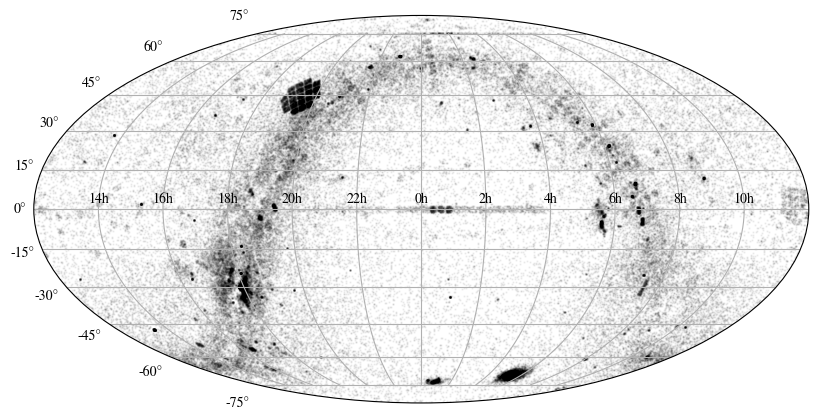

In [36]:
ra = coord.Angle((np.asarray(features.iloc[:,0])).astype(float)*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle((np.asarray(features.iloc[:,1])).astype(float)*u.degree)
c=np.log(np.asarray(features.iloc[:,9]))
#s=(np.log(np.asarray(output_df.iloc[:,10]))+20)/3

plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian,color='k',s=0.5,vmin=8,vmax=11,alpha=0.05)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
plt.grid(True)
plt.show()

In [29]:
(np.asarray(features.iloc[:,0]))

array([132.97777915, 169.69048751, 181.71847765, ..., 269.41368503,
       269.4138186 , 283.65328077])

In [37]:
features

RA           Dec      PMRA      PMDec        RA       Dec   
             Value         Value     Value      Value     Error     Error   
               deg           deg    mas/yr     mas/yr       deg       deg   
                 -             -         -          -         -         -   
                 -             -         -          -         -         -   
                 -             -         -          -         -         -  \
0       119.491766  -60.84592548 -4.695354  11.037897  4.301245  4.194995   
1       119.554176  -60.87405889 -4.234626  11.173420  6.231032  6.574029   
..             ...           ...       ...        ...       ...       ...   
117128  269.413819   -31.5183393 -2.775931  -9.575798  2.294416  1.854862   
117129  283.653281  -11.71105754 -4.069475  -3.876480  6.794917  6.649671   

            PMRA     PMDec         Teff          Lum  Teff   Lum     Distance   
           Error     Error        Value        Value Error Error        Value   
          mas/yr    mas/yr            K         LSun     K  LSun           pc   
               -         -            -            -     -     -            -   
               -         -            -            -     -     -            -   
               -         -            -            -     -     -            -  \
0       0.019851  0.018965  8599.958625    39.418834     0     0   405.401029   
1       0.029275  0.028408  9905.753519   111.562348     0     0   409.116918   
..           ...       ...          ...          ...   ...   ...          ...   
117128  0.097424  0.064118  3131.848813  1573.178991     0     0  7169.292882   
117129  0.031309  0.024490  3559.420618  1640.625214     0     0  4650.313603   

          E(B-V)      logg    [Fe/H] Distance    E(B-V)      logg    [Fe/H]   
           Value     Value     Value    Error     Error     Error     Error   
             mag       dex       dex       pc       mag       dex       dex   
               -         -         -        -         -         -         -   
               -         -         -        -         -         -         -   
               -         -         -        -         -         -         -  \
0       0.052491  3.868009 -0.340271        0  0.000000  0.000000  0.000000   
1       0.052808  3.828682 -0.343239        0  0.000000  0.000000  0.000000   
..           ...       ...       ...      ...       ...       ...       ...   
117128  1.547065  0.112689 -1.310055        0  0.000000  0.000000  0.000000   
117129  0.587042  0.175496 -0.756548        0  0.007194  0.040131  0.105873   

           GAIA/GAIA3.Gbp       GAIA/GAIA3.G     GAIA/GAIA3.Grp   
                    Value              Value              Value   
                       Jy                 Jy                 Jy   
          5035.7502754443    5822.3887136979    7619.9599926215   
          2157.5049836097    4052.9683037357    2924.4362576966   
       1.1103772593006023 0.9038786989268854 0.5996680415563764  \
0               0.8595203          0.8171172          0.7233661   
1               1.8710549          1.7138734            1.44176   
..                    ...                ...                ...   
117128      3.8496615e-05       0.0016043915        0.005560504   
117129                NaN                NaN                NaN   

       Hipparcos/Hipparcos.Hp_MvB  TYCHO/TYCHO.B_MvB  TYCHO/TYCHO.V_MvB   
                            Value              Value              Value   
                               Jy                 Jy                 Jy   
                           5586.0             4220.0             5350.0   
                  2405.6922033101    741.38613610869    1133.5568319306   
               0.9569406937310104 1.3607253583140135 1.0172628209379844  \
0                             NaN          0.9327919          1.0258495   
1                             NaN           2.266651          2.1671238   
..                            ...                ...                